In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,  classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import ipaddress

import warnings
warnings.simplefilter('ignore')

## Data preprocessing

In [2]:
DATADIR = '/home/infres/abiapo/prim/data'

In [3]:
data = pd.read_csv(DATADIR+'/balance_mix_data.csv')
data.head()

,Unnamed:_0,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,...,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,SimillarHTTP,Inbound,Label,label
0,112140,172.16.0.5-192.168.50.1-44231-8387-17,172.16.0.5,44231,192.168.50.1,8387,17,2018-12-01 13:45:46.994571,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,TFTP,1
1,25309,172.16.0.5-192.168.50.1-891-63192-17,172.16.0.5,891,192.168.50.1,63192,17,2018-12-01 12:14:48.493601,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_SNMP,1
2,3538,172.16.0.5-192.168.50.1-649-33920-17,172.16.0.5,649,192.168.50.1,33920,17,2018-12-01 10:36:57.214865,1620,126,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_NTP,1
3,11531,192.168.10.50-192.168.50.6-22-56370-6,192.168.50.6,56370,192.168.10.50,22,6,2018-11-03 12:46:39.696861,8996366,6,...,2995940.0,2995940.0,6000423.0,0.0,6000423.0,6000423.0,0,1,BENIGN,0
4,1489,192.168.50.6-4.2.2.4-58840-53-17,192.168.50.6,58840,4.2.2.4,53,17,2018-12-01 10:59:03.241570,20681,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,BENIGN,0


In [4]:
data = data.drop(['Unnamed:_0'],axis=1)
data['Source_IP'] = data['Source_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data['Destination_IP'] = data['Destination_IP'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data = data.drop(['Flow_ID'],axis=1)
data = data.drop(['Timestamp'],axis=1)
data = data.drop(['SimillarHTTP'],axis=1)
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [5]:
X = data.iloc[:,:-2]
y = data.iloc[:,-1].to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)   

# Feature scaling

In [7]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = pd.DataFrame(std_scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

# Feature selection

In [8]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [9]:
#Select top 2 features based on f_classif
selector = SelectKBest(f_classif, k = 35).fit(X_train, y_train)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
preselect_feature = featureScores.nlargest(28,'Score')['Specs'].to_list()

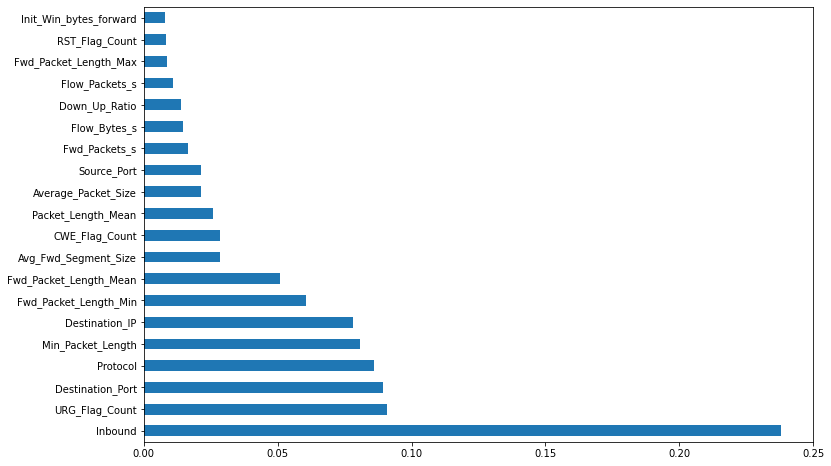

In [10]:
plt.figure(figsize=(12,8))
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train[preselect_feature],y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train[preselect_feature].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [11]:
principal_feature = feat_importances.nlargest(20).index.to_list()

In [12]:
X_train = X_train[principal_feature]
X_test = X_test[principal_feature]

## Models

In [13]:
def cal_accuracy(y_test, y_pred): 
    print("Confusion Matrix: ")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 
    print(classification_report(y_test, y_pred))

#### Decision Tree

Confusion Matrix: 
Accuracy :  99.99767160286859
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



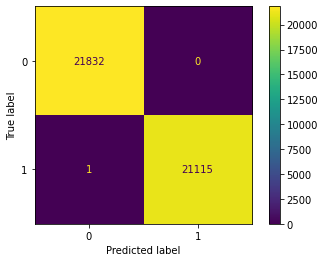

In [14]:
from sklearn.tree import DecisionTreeClassifier 
clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
clf_entropy.fit(X_train, y_train) 
y_pred_entropy = clf_entropy.predict(X_test)
cal_accuracy(y_test, y_pred_entropy)

##### Checking overfitting

In [15]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_entropy.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_entropy.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 1.0000


#### Naive Bayes

Confusion Matrix: 
Accuracy :  97.67160286858527
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21832
           1       1.00      0.96      0.98     21116

    accuracy                           0.98     42948
   macro avg       0.98      0.98      0.98     42948
weighted avg       0.98      0.98      0.98     42948



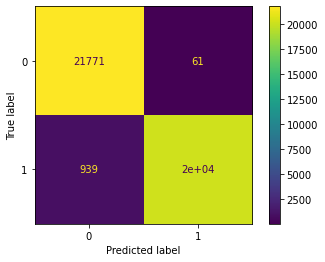

In [16]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
y_pred_nb = gnb.predict(X_test)
cal_accuracy(y_test, y_pred_nb)

In [17]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

Training set score: 0.9758
Test set score: 0.9767


In [18]:
pred_prob_dt = clf_entropy.predict_proba(X_test)
pred_prob_nb = gnb.predict_proba(X_test)

# roc curve for models
fpr_dt, tpr_dt, thresh_dt = roc_curve(y_test, pred_prob_dt[:,1], pos_label=1)
fpr_nb, tpr_nb, thresh_nb = roc_curve(y_test, pred_prob_nb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_dt = roc_auc_score(y_test, pred_prob_dt[:,1])
auc_score_nb = roc_auc_score(y_test, pred_prob_nb[:,1])

print(auc_score_dt, auc_score_nb)

0.9999763212729684 0.9991436385334119


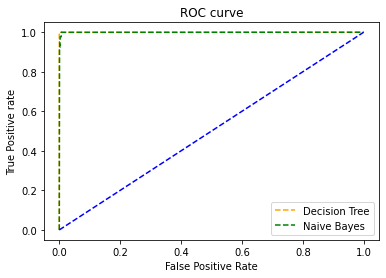

In [19]:
#plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_dt, tpr_dt, linestyle='--',color='orange', label='Decision Tree')
plt.plot(fpr_nb, tpr_nb, linestyle='--',color='green', label='Naive Bayes')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

#### Logistic Regression

Confusion Matrix: 
Accuracy :  99.86495296637794
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



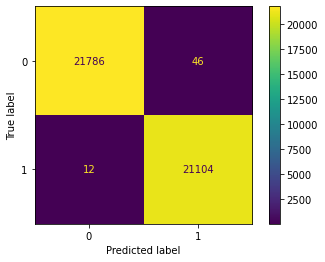

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', random_state = 0)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
cal_accuracy(y_test, y_pred_lr)

In [21]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.9986
Test set score: 0.9986


#### Support Vector Machine with gaussian kernel

Confusion Matrix: 
Accuracy :  99.97671602868586
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



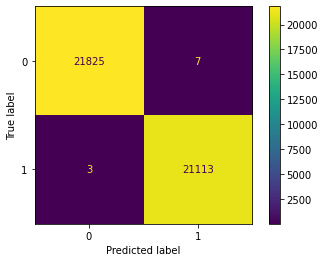

In [22]:
from sklearn.svm import SVC
clf_svm = SVC(kernel = 'rbf', random_state = 0,C=10.0, gamma=0.1,probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svc = clf_svm.predict(X_test)
cal_accuracy(y_test, y_pred_svc)

In [23]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_svm.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_svm.score(X_test, y_test)))

Training set score: 0.9998
Test set score: 0.9998


In [24]:
pred_prob_logreg = logreg.predict_proba(X_test)
pred_prob_svm = clf_svm.predict_proba(X_test)

# roc curve for models
fpr_logreg, tpr_logreg, thresh_logreg = roc_curve(y_test, pred_prob_logreg[:,1], pos_label=1)
fpr_svm, tpr_svm, thresh_svm = roc_curve(y_test, pred_prob_svm[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_logreg = roc_auc_score(y_test, pred_prob_logreg[:,1])
auc_score_svm = roc_auc_score(y_test, pred_prob_svm[:,1])

print(auc_score_logreg, auc_score_svm)

0.9997422151043937 0.9999370071241298


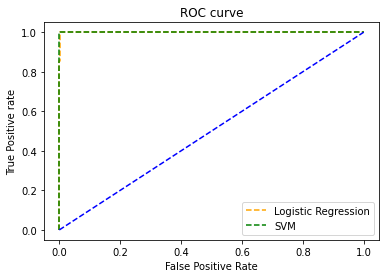

In [25]:
#plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_logreg, tpr_logreg, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, linestyle='--',color='green', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

#### K Nearest Neighbor

Confusion Matrix: 
Accuracy :  99.97904442581726
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



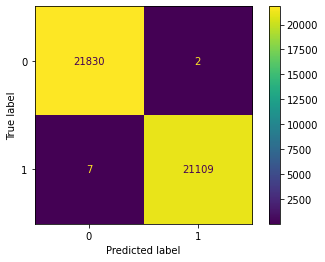

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
cal_accuracy(y_test, y_pred_knn)

In [27]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(knn.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(knn.score(X_test, y_test)))

Training set score: 0.9998
Test set score: 0.9998


#### Random Forest

Confusion Matrix: 
Accuracy :  100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



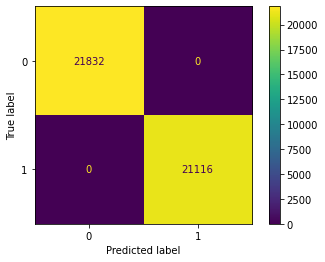

In [28]:
from sklearn.ensemble import RandomForestClassifier
rndForest =RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
rndForest.fit(X_train,y_train)
y_pred_rf = rndForest.predict(X_test)
cal_accuracy(y_test, y_pred_rf)

In [29]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(rndForest.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(rndForest.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 1.0000


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob_knn = knn.predict_proba(X_test)
pred_prob_rf = rndForest.predict_proba(X_test)

# roc curve for models
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, pred_prob_knn[:,1], pos_label=1)
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_knn = roc_auc_score(y_test, pred_prob_knn[:,1])
auc_score_rf = roc_auc_score(y_test, pred_prob_rf[:,1])

print(auc_score_knn, auc_score_rf)

0.9999533431898386 1.0


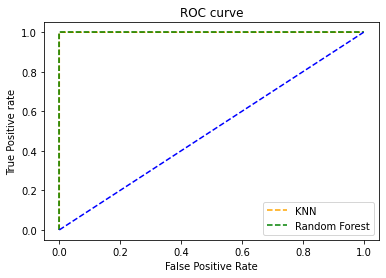

In [31]:
#plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_knn, tpr_knn, linestyle='--',color='orange', label='KNN')
plt.plot(fpr_rf, tpr_rf, linestyle='--',color='green', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

 #### LightGBM

Confusion Matrix: 
Accuracy :  99.99767160286859
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



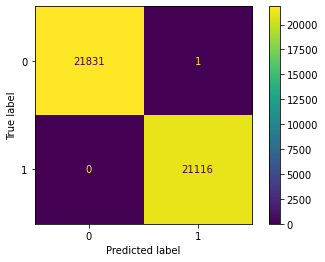

In [32]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)
cal_accuracy(y_test, y_pred_lgb)

In [33]:
print('Training set score: {:.4f}'.format(lgb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgb.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 1.0000


#### XGBoost

Confusion Matrix: 
Accuracy :  99.99767160286859
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



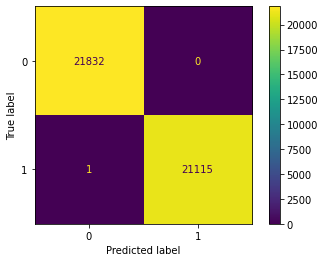

In [34]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
cal_accuracy(y_test, y_pred_xgb)

In [35]:
print('Training set score: {:.4f}'.format(xgb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(xgb.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 1.0000


In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob_xgb = xgb.predict_proba(X_test)
pred_prob_lgb = lgb.predict_proba(X_test)

# roc curve for models
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)
fpr_lgb, tpr_lgb, thresh_lgb = roc_curve(y_test, pred_prob_lgb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_xgb = roc_auc_score(y_test, pred_prob_xgb[:,1])
auc_score_lgb = roc_auc_score(y_test, pred_prob_lgb[:,1])

print(auc_score_xgb, auc_score_lgb)

1.0 0.9999999783082384


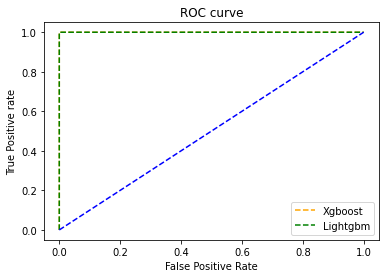

In [37]:
# plot roc curves
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='orange', label='Xgboost')
plt.plot(fpr_lgb, tpr_lgb, linestyle='--',color='green', label='Lightgbm')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_xgb_lgb',dpi=300)
plt.show()

#### Multi Layer Perceptron

Confusion Matrix: 
Accuracy :  99.97671602868586
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21832
           1       1.00      1.00      1.00     21116

    accuracy                           1.00     42948
   macro avg       1.00      1.00      1.00     42948
weighted avg       1.00      1.00      1.00     42948



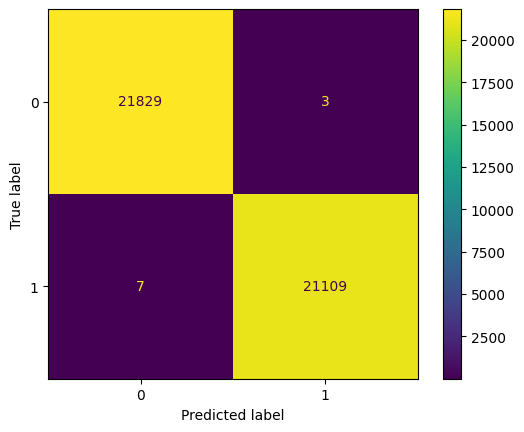

In [38]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(250,100),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam')
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_test)
plt.style.use('default')
cal_accuracy(y_test, y_pred_mlp)

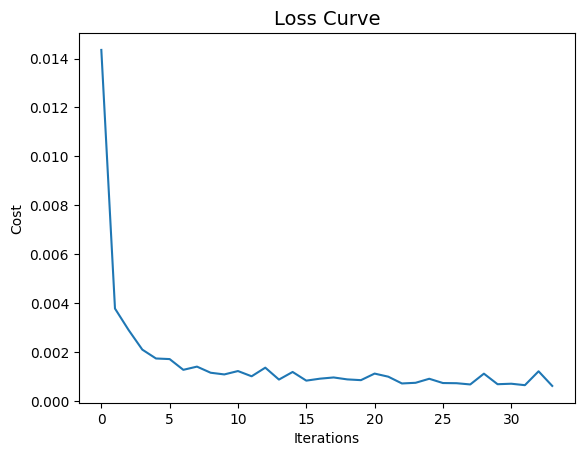

In [39]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [40]:
print('Training set score: {:.4f}'.format(mlp_clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(mlp_clf.score(X_test, y_test)))

Training set score: 0.9999
Test set score: 0.9998


In [41]:
pred_prob_mlp = mlp_clf.predict_proba(X_test)

# roc curve for models
fpr_mlp, tpr_mlp, thresh_mlp = roc_curve(y_test, pred_prob_mlp[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score_mlp = roc_auc_score(y_test, pred_prob_mlp[:,1])

print(auc_score_mlp)

0.9999998958795439


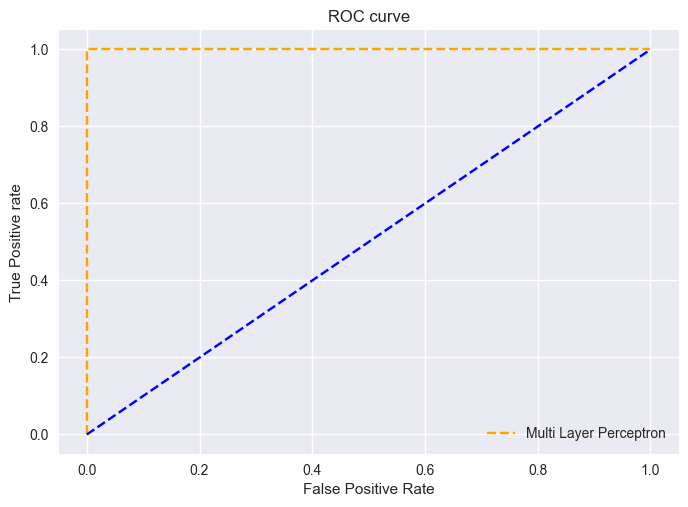

In [42]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_mlp, tpr_mlp, linestyle='--',color='orange', label='Multi Layer Perceptron')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();